In [1]:
### imports
import pandas as pd
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.xgb import XGB
from src.datahandling.preprocessing import *

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# XG-Boost Regression

XG Boost stands for "Extreme Gradient Boosting". It is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. The algorithms comes along with a lot of hyperparameters to tune. Since this is not feasible with the hardware at hand, we will use a randomized search over the hyperparameter space.

Additionally, there were some problems with executing a model fit. We needed to downgrade the version of xgboost to 0.90. This comes along with some warnings. Consider, upgrading the version if you are able to call the fit function. Please find further informations on https://github.com/dmlc/xgboost/issues/7504 (newest one I could find).

In [2]:
model = Pipeline(
    [
        ("norm", Normalizer()),
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("xgb", XGB()),
    ]
)

param_grid = {
    "st__window_size": [8],
    "st__horizon": ["10min", "hourly", "daily"],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__max_depth": [3, 4, 5],
    "xgb__min_child_weight": [1, 2, 3],
}

## British Dataset - Kelmarsh

In [3]:
### loading data
TURBINE_ID = 2
data_brit = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning  data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
    ],
)
data_brit = cleaner.transform(data_brit)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_brit, test_start=test_start, test_end=test_end, target_var="power"
)

In [4]:
### hyperparameter tuning
### RUNTIME: ~ 45 min on my machine
do_gridsearch = False

if do_gridsearch:

    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        n_iter=15,
        refit=False,
    )

    grid_search.fit(X_train, y_train)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_xgb_brit.csv")
    # reload necessary 
    res_gs_brit = pd.read_csv("../results/results_gs_xgb_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_xgb_brit.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


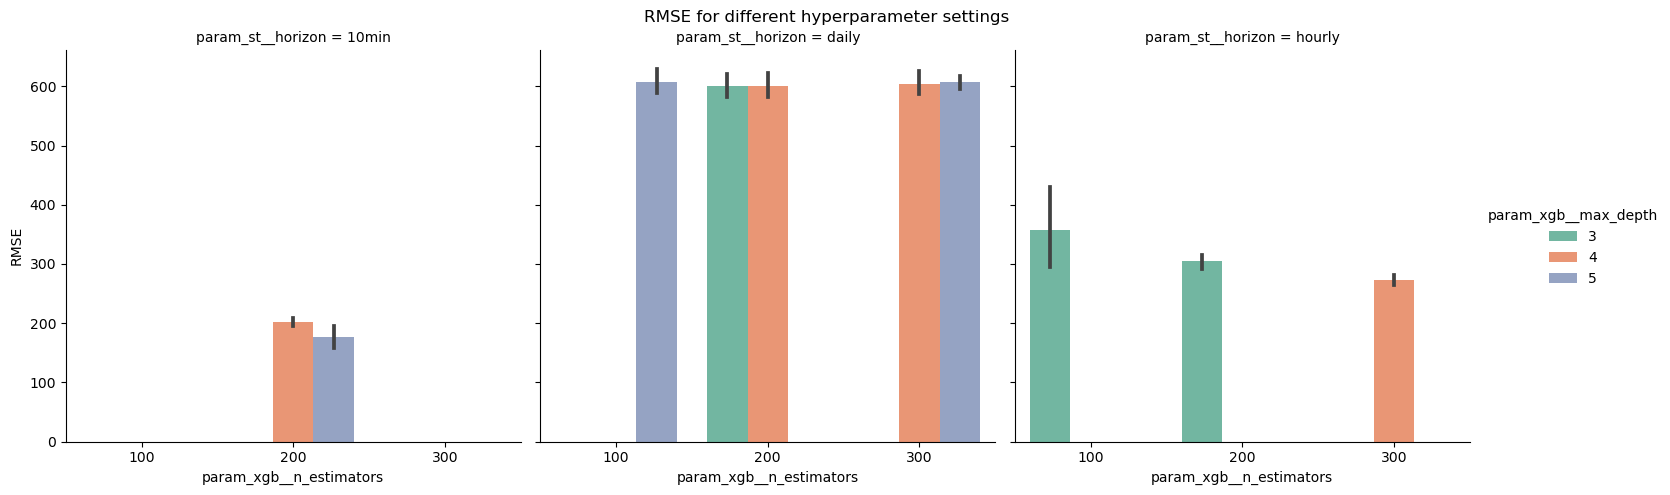

In [5]:
vis.plot_gridsearch_results(res_gs_brit, x="param_xgb__n_estimators", hue="param_xgb__max_depth")

In [6]:
### extract best parameters of each model for each horizon
best_params_brit_xgb = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_xgb.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_xgb.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'xgb__n_estimators': 200, 'xgb__min_child_weight': 3, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'st__window_size': 8, 'st__horizon': '10min'}
Best parameters for horizon daily: {'xgb__n_estimators': 300, 'xgb__min_child_weight': 2, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'daily'}
Best parameters for horizon hourly: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2, 'st__window_size': 8, 'st__horizon': 'hourly'}


In [7]:
### plot predictions for best models
# refit models
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    new_model = model.set_params(
        **ast.literal_eval(best_params_brit_xgb.loc[horizon][0])
    )
    new_model.fit(X_train, y_train)
    predictions[horizon] = new_model.predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

[15:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


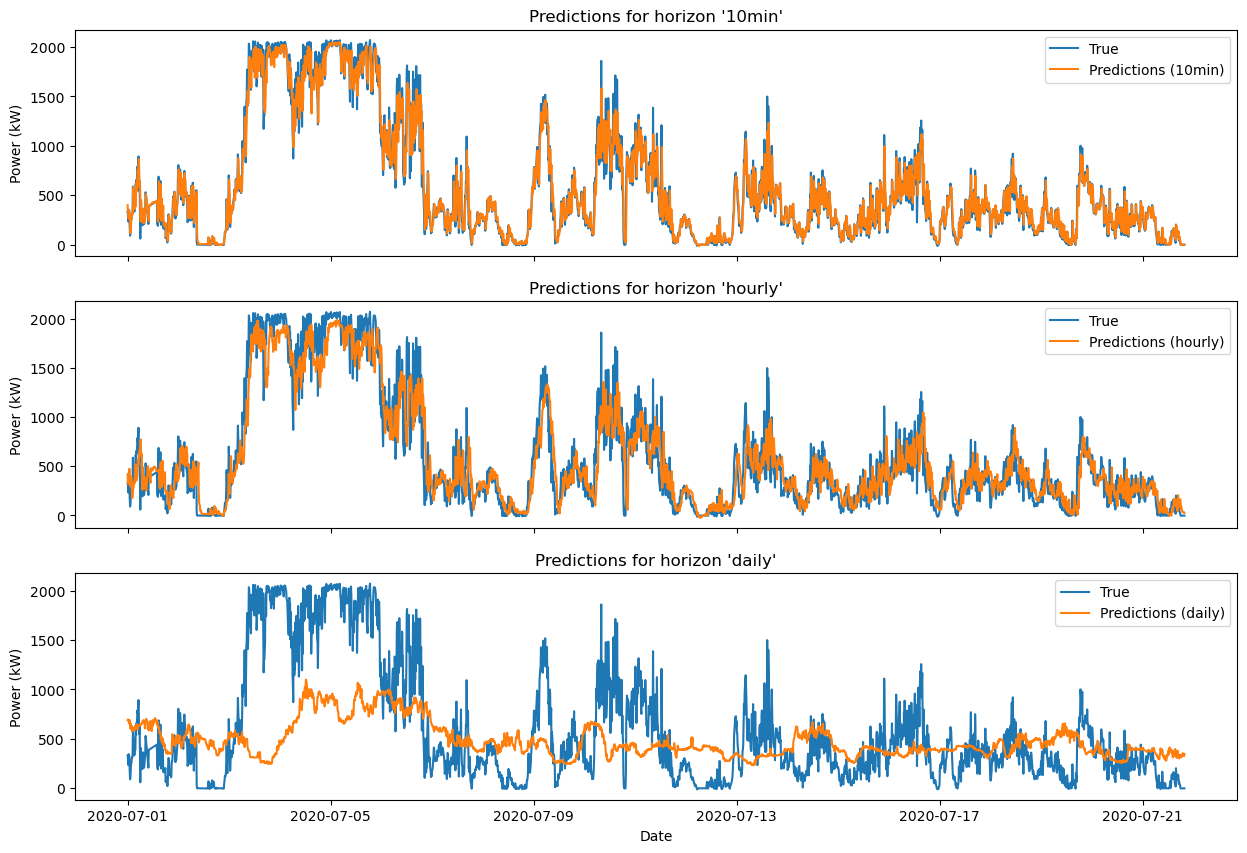

In [8]:
### plot first 3000 predictions
vis.plot_predictions(predictions[:3000], y_test[:3000])

## Brazilian Dataset - Beberine

In [9]:
### loading data
TURBINE_ID = 1
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data 
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
    ],
)
data_braz = cleaner.transform(data_braz)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

In [10]:
### hyperparameter tuning
### RUNTIME: ~ 4 min on my machine
do_gridsearch = False

if do_gridsearch:
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        n_iter=15, 
        refit=False,
    )
    grid_search.fit(X_train, y_train)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_xgb_braz.csv")
    # reload sometimes necessary for data type reasons
    res_gs_braz = pd.read_csv("../results/results_gs_xgb_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_xgb_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


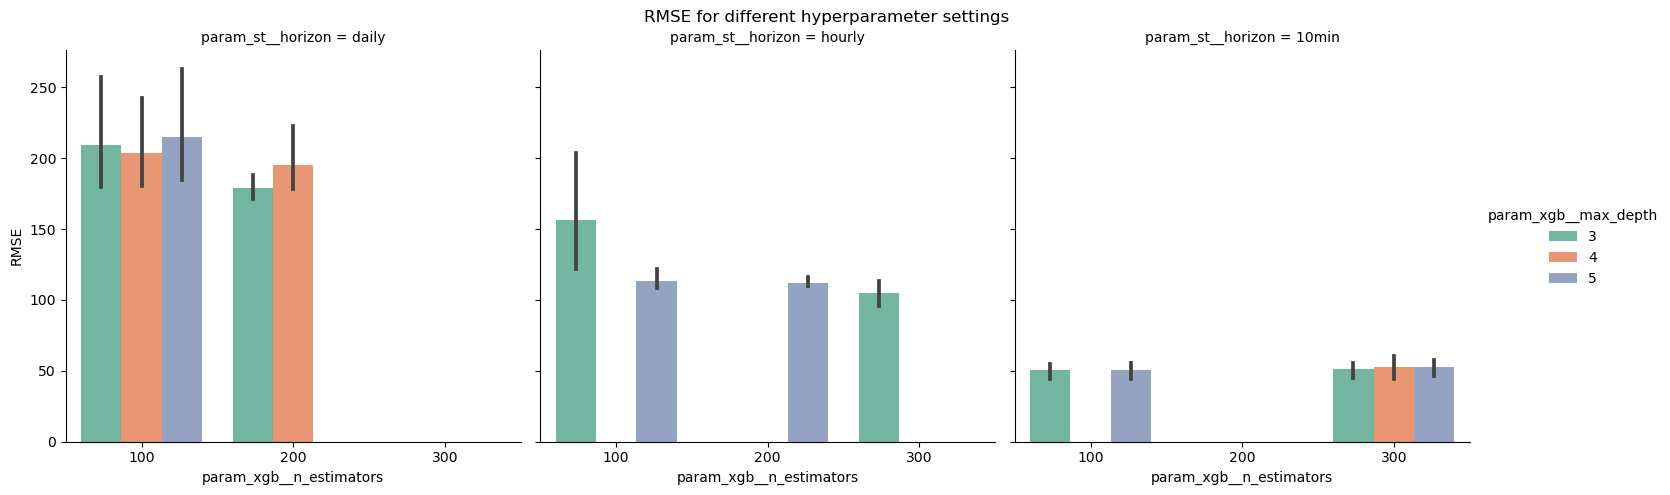

In [11]:
vis.plot_gridsearch_results(res_gs_braz, x="param_xgb__n_estimators", hue="param_xgb__max_depth")

In [12]:
### extract best parameters of each model for each horizon
best_params_braz_xgb = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_xgb.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_xgb.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 3, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'st__window_size': 8, 'st__horizon': '10min'}
Best parameters for horizon daily: {'xgb__n_estimators': 200, 'xgb__min_child_weight': 2, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'daily'}
Best parameters for horizon hourly: {'xgb__n_estimators': 300, 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'hourly'}


In [13]:
### plot predictions for best models
# refit models
## for some reason this crashes my kernel, so I commented it out
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    new_model = model.set_params(
        **ast.literal_eval(best_params_braz_xgb.loc[horizon][0])
    )
    new_model.fit(X_train, y_train)
    predictions[horizon] = new_model.predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

[15:46:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


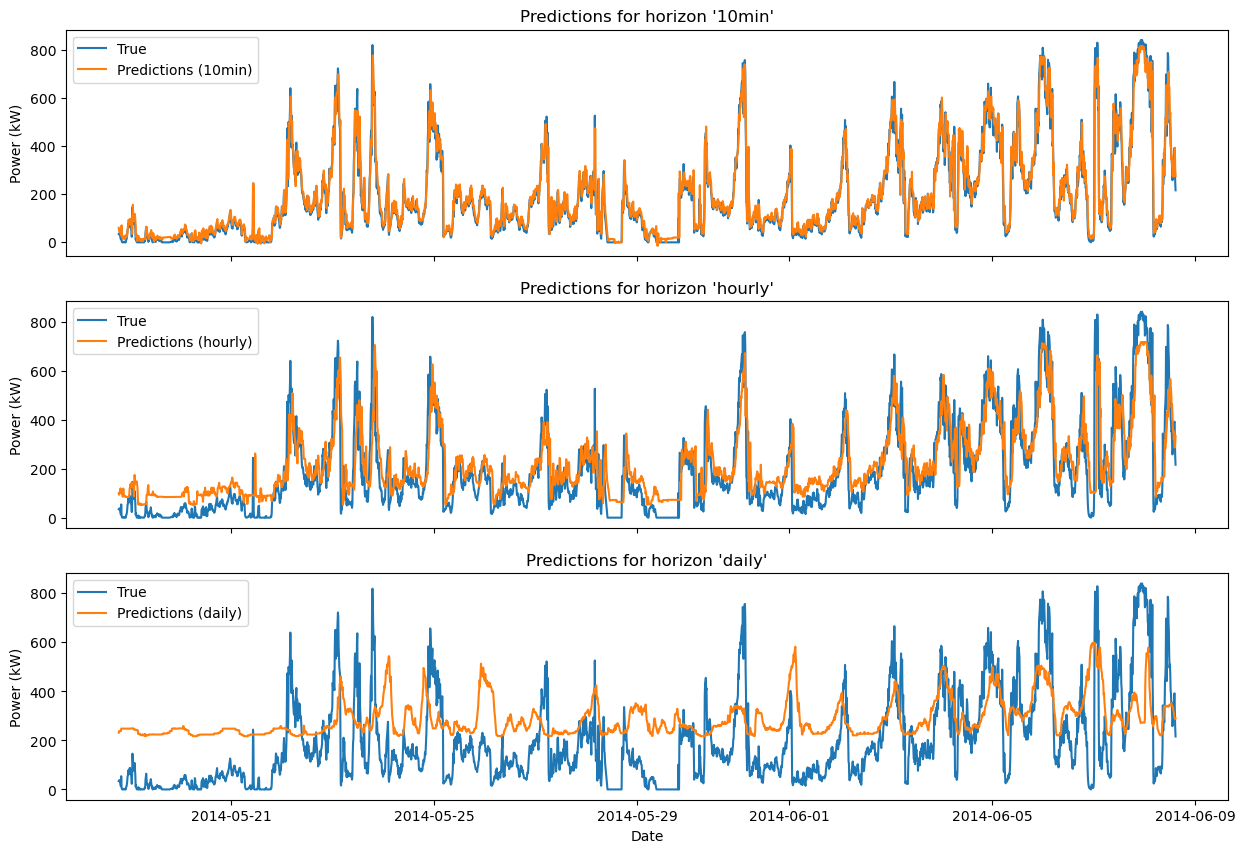

In [14]:
### plot first 3000 predictions
vis.plot_predictions(predictions[:3000], y_test[:3000])

## Transfer Learning Challenge

For the transfer learning challenge we pursue the same steps as in the respective section in `RegressionVariants.ipynb`.

In [15]:
model = Pipeline(
    [
        ("fs", FeatureSelector(features=["power", "wind_speed", "wind_direction", "rotor_speed"])),
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("xgb", XGB()),
    ]
)

In [16]:
norm_brit = Normalizer()
norm_brit.fit(data_brit)
norm_braz = Normalizer()
norm_braz.fit(data_braz)

Normalizer()

[15:47:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


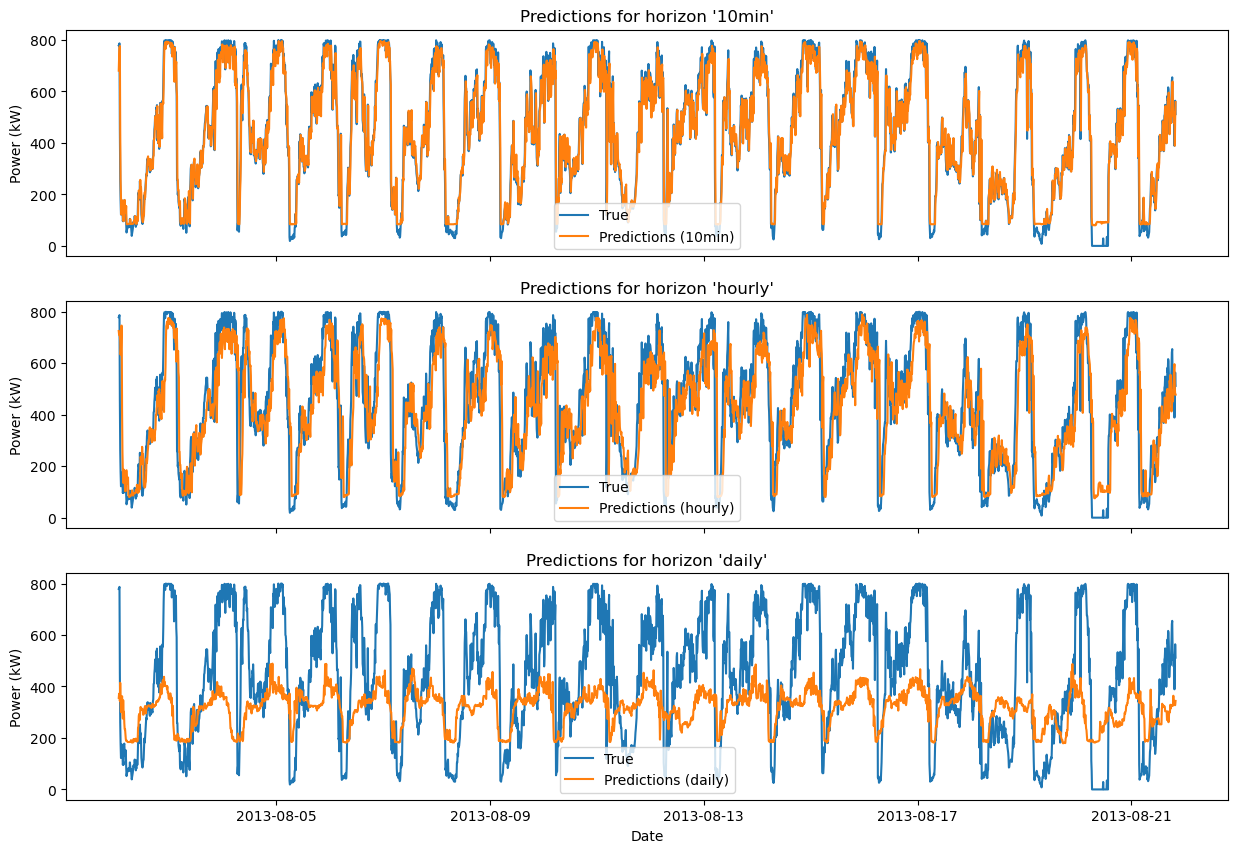

RMSE for horizon 10min: 60.63151369706436
MAE for horizon 10min: 42.280999269421145
RMSE for horizon hourly: 118.40854546796679
MAE for horizon hourly: 82.5805259596259
RMSE for horizon daily: 200.00407083196302
MAE for horizon daily: 164.8931272119339


In [17]:
### predicting brazilian from british data
X_train = norm_brit.transform(data_brit)
y_train = X_train["power"]
X_test = norm_braz.transform(data_braz)
y_test = data_braz["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_braz.scale_[0]) + norm_braz.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[152:3000],
    y_test.iloc[152:3000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")

[15:48:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


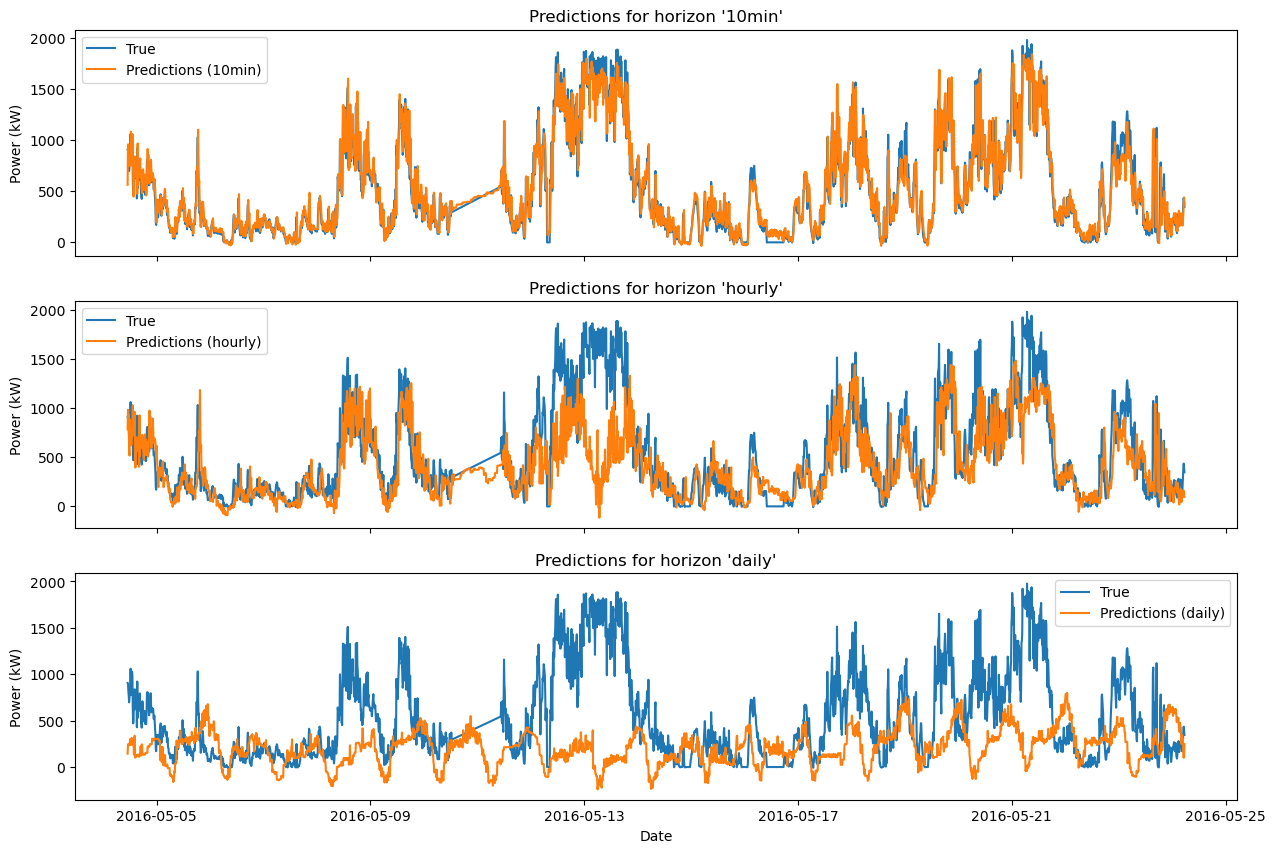

RMSE for horizon 10min: 168.45246963482327
MAE for horizon 10min: 112.7271326732437
RMSE for horizon hourly: 355.60541691463925
MAE for horizon hourly: 255.060055615927
RMSE for horizon daily: 672.2253923035755
MAE for horizon daily: 533.4890957558736


In [18]:
### predicting british from brazilian data
X_train = norm_braz.transform(data_braz)
y_train = X_train["power"]
X_test = norm_brit.transform(data_brit)
y_test = data_brit["power"]

predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    model.set_params(**{"st__horizon": horizon})
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_test) * norm_brit.scale_[0]) + norm_brit.mean_[0]
    predictions[horizon] = y_pred

predictions = pd.DataFrame(predictions, index=X_test.index)
# plot first 3000 predictions
vis.plot_predictions(
    predictions.iloc[152:3000],
    y_test.iloc[152:3000],
)

# print errors
for horizon in predictions.columns:
    print(f"RMSE for horizon {horizon}: {mean_squared_error(y_test[152:], predictions[horizon][152:], squared=False)}")
    print(f"MAE for horizon {horizon}: {mean_absolute_error(y_test[152:], predictions[horizon][152:])}")


__Summary:__